##  Car Price Prediction - Preprocessing

###  Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pprint
import joblib

#Python iterators for efficient looping
import itertools

#Hyperparameter selection
from sklearn.model_selection import ParameterGrid

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

### Import Raw Data

In [2]:
#Import data - austin, dallas, houston, and san antonio.  Two snapshots.

austin1=pd.read_json('json/austin_ford_2019-11-18.json')
dallas1=pd.read_json('json/dallas_ford_2019-11-18.json')
ep1=pd.read_json('json/ep_ford_2019-11-18.json')
houston1=pd.read_json('json/houston_ford_2019-11-18.json')
sa1=pd.read_json('json/sa_ford_2019_11_18.json')

austin2=pd.read_json('json/austin_ford_2019-12-29.json')
dallas2=pd.read_json('json/dallas_ford_2019-12-29.json')
ep2=pd.read_json('json/ep_ford_2019-12-29.json')
houston2=pd.read_json('json/houston_ford_2019-12-29.json')
sa2=pd.read_json('json/sa_ford_2019_11_18.json')

vehicle = pd.DataFrame()
for dframe in [austin1, dallas1, ep1, houston1, sa1, austin2, dallas2, ep2, houston2, sa2]:
    vehicle = vehicle.append(dframe, ignore_index = True)
display(f'vehicle has {len(vehicle)} rows:', vehicle.tail(1))

'vehicle has 21080 rows:'

,URL_Vehicle,Title,Price,SubLoc,Body,AttribDictionary,ImageDictionary
21079,https://sanantonio.craigslist.org/ctd/d/san-an...,2008 FORD F250 SUPER DUTY CREW CAB,$16900,(1200 basse rd San Antonio TX),"[\n , \n2008 FORD F250 SUPER DUTY CREW ...",{'0': '<span><b>2008 ford f-250 super duty cre...,{'0': 'https://images.craigslist.org/00k0k_9Lu...


In [3]:
#The vehicle 'Body' is a comma-delimited list.  Join list into a single string.
vehicle['Body'] = vehicle['Body'].str.join(',')

#Remove whitespace.  Replace NaNs with None.
vehicle['SubLoc'] = vehicle['SubLoc'].str.strip()
SubLoc_dict={'SubLoc': {np.nan : 'None'}}
vehicle.replace(SubLoc_dict, inplace=True)

In [4]:
#Add feature columns and view dataframe
print('vehicle length:', len(vehicle))
print('vehicle type:', type(vehicle))

vehicle.insert(2,'Location',np.nan)
vehicle.insert(3,'Year',np.nan)
vehicle.insert(4,'Year_in_Title',np.nan)
vehicle.insert(5,'Odometer',np.nan)
vehicle.insert(6,'RawMake',np.nan)
vehicle.insert(7,'Make',np.nan)
vehicle.insert(8,'Model',np.nan)
vehicle.insert(9,'Trim',np.nan)
vehicle.insert(10,'Seller',np.nan)
vehicle.head(1)

vehicle length: 21080
vehicle type: <class 'pandas.core.frame.DataFrame'>


,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...


In [5]:
#Helper functions.

def match_regex_patt(df, target_col, regex_patt, no_match_value='None'):
    '''Returns regex_patt matches as list.  Case is ignored.'''
    matchList=[]
    cnt = 0
    for idx in df.index:
        m = re.search(regex_patt, df.loc[idx, target_col], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
        if m is not None:
            matchList.append(m.group(1).lower())
        else:
            cnt+=1
            matchList.append(no_match_value)
    print(f'## In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.\n')
    return matchList

def findall_regex_patt(df, target_col, regex_patt, max_items, no_match_value='None'):
    '''Returns regex_patt matches found left-to-right as list.  Case is ignored.'''
    findallList=[]
    cnt = 0
    for idx in df.index:
        allm = re.findall(regex_patt, df.loc[idx, target_col] + " ", flags=re.IGNORECASE) #return all matches left-to-right
        allm = allm[0:max_items]  #first two items
        oneString = ("").join(allm).strip() #convert list to string and remove any spaces.
        if len(oneString) > 0:
            findallList.append(oneString.lower())
        else:
            cnt+=1
            findallList.append(no_match_value)
    print(f'## In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.\n')
    return findallList

def findall_body_regex_patt(df, target_col, regex_patt, max_items, no_match_value='None'):
    '''Returns regex_patt matches found left-to-right as list.  Case is ignored.
       Each Model included in pattern.'''
    findallList=[]
    cnt = 0
    for idx in df.index:
        patt_w_model = df.loc[idx, "Model"] + regex_patt  #regex pattern is: Model + Pattern
        allm = re.findall(patt_w_model, df.loc[idx, target_col] + " ", flags=re.IGNORECASE) #return all matches left-to-right
        allm = allm[0:2]  #first two items
        oneString = ("").join(allm).strip() #convert list to string and remove any spaces.
        if len(oneString) > 0:
            findallList.append(oneString.lower())
        else:
            cnt+=1
            findallList.append(no_match_value)
    print(f'## In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.\n')
    return findallList


#****************************************Target Encoder******************************************
from category_encoders.target_encoder import TargetEncoder

def target_encode_categ(encode_cols, train, test, target, encoder):
    '''Returns encoded categorical features.  Encoded feature is a blend of
    (1) ExpectedVal( trainTarget | FeatureClass) and 
    (2) "Prior": ExpectedVal(Target) over all training data.  
    
    Sets testTarget to NaN to stop data leakage.
    
    Encoder smoothing balances Class average vs Prior. Higher smoothing is stronger
    regularization.
    
    Arguments
    ---------
    train: training data including target Y
    test: test data including target Y
    target: target Y
    encoder: TargetEncoder(cols_to encode, smoothing_float_value).  
    
    See https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html
    for more hyperparameters.'''
    
    trn=train.copy(); tst=test.copy();
    if target in tst.columns:   #Omit any test targets from encoding.  Prevents leakage.
        tst[target] = np.nan  
    fullX = trn.append(tst)
    fullY = fullX.pop(target)       
    fullX_enc = encoder.fit_transform(fullX, fullY)
    
    #Overwrite train/test features with encoded features.
    train[encode_cols] = fullX_enc.loc[train.index, encode_cols]
    test[encode_cols] = fullX_enc.loc[test.index, encode_cols]
    return train, test

def multivar_impute(train, test, target):
    '''Impute values with regression on numeric columns, excluding
    the target. Returns DataFrames.'''
    
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    num_cols_ex_targ = train.select_dtypes(exclude='object').columns.tolist()
    num_cols_ex_targ.remove(target)
    
    #Get imputed dfs.
    ii = IterativeImputer(max_iter=10, random_state=5)
    train_impX = pd.DataFrame(ii.fit_transform(train[num_cols_ex_targ]), index=train.index, columns=num_cols_ex_targ)
    test_impX = pd.DataFrame(ii.transform(test[num_cols_ex_targ]), index=test.index, columns=num_cols_ex_targ)

    #Overwrite original features with imputed features.
    train[num_cols_ex_targ] = train_impX
    test[num_cols_ex_targ] = test_impX
    return train, test

In [6]:
#Helper model to tune hyperparameters

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import uniform
from skopt.space import Real
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
    

def run_LGBM(train, test):    
    #Split out Price
    trainX = train.copy()
    trainY = trainX.pop('Price')
    testX = test.copy()
    testY = testX.pop('Price')
    display('Input data:', trainX.head(2))

    #CREATE LightGBM model with random search.

    clf = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=1, silent=1)

    param_grid={"learning_rate": Real(0.01, 1.0, 'log-uniform'),
                "n_estimators": randint(100,200),
                "num_leaves": randint(2, 600), 
                "max_depth": randint(0, 40),
                "min_data_in_leaf": randint(10, 200),  #prevents overfitting
                "max_bin": randint(100,60000),
                "bagging_fraction": Real(0.01, 0.1, 'uniform'),
                "feature_fraction": uniform(0.01, 0.99),
                "subsample_for_bin": randint(100000, 600000),
                "lambda_l2": Real(1e-9, 1000, 'log-uniform'),
                "lambda_l1": Real(1e-9, 1, 'log-uniform'),          
                }

    #Instantiate random_search.
    lgb_model = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=30, cv=5, n_jobs=-1, refit=True,\
                               scoring='neg_mean_absolute_error', return_train_score=False,random_state=40)

    #Tune model with CV. Model will automatically refit on full train with best parameters.
    lgb_model.fit(trainX, trainY)

    #Tuned model best score.
    best_score_std = lgb_model.cv_results_['std_test_score'][lgb_model.best_index_]
    print(f'## Grid iters checked: {len(lgb_model.cv_results_["params"])}','\n')
    mean_score = np.round(lgb_model.cv_results_["mean_test_score"],0)
    print(f'## mean valid scores: {mean_score})', '\n')
    print(f'## best valid score: {lgb_model.best_score_:.0f} +- {best_score_std:.0f}','\n')   
    print('## Best parameters:')
    pprint.pprint(lgb_model.best_params_)
    print('\n')

    #PREDICT model on full data (thanks to refit).
    y_test_pred = lgb_model.predict(testX)
    mean_abs_error = score_algo(lgb_model, testX, testY, y_test_pred)  

    #Get feature importances using eli5.
    perm = PermutationImportance(lgb_model, n_iter=20).fit(testX, testY)
    display(eli5.show_weights(perm, feature_names = testX.columns.tolist()))
    return lgb_model, round(lgb_model.best_score_,1), round(best_score_std,1), round(mean_abs_error,1)

#Score predictions of fitted model.
def score_algo(model, X, y, prediction):
    print('-----------------------------------------------')
    print(f'##### {type(model).__name__} - Prediction Scores:')
    print('-----------------------------------------------')
    print('RMSE:', round(np.sqrt(mean_squared_error(y, prediction)), 1))
    print(' R^2:', round(r2_score(y, prediction), 4))
    mean_abs_err = round(mean_absolute_error(y, prediction),1)
    print(' MAE:', mean_abs_err)
    return mean_abs_err

C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
# Residuals helper function
def plot_residuals(predicted, true):
    '''
    Plots predicted vs error.  Error = true - predicted.  Marks
    three standard deviation error from mean with orange bars.  
    Plots error histogram.  Plots regression of predicted vs true.
    Returns indices of 3 sigma anomalies.
    '''
    anomaly_locs = []
    error = true - predicted
    print('error count:', len(error), '| error avg:', round(error.mean(),1), '| high pred percent:', round(100*len(error[error<0])/len(error),1), '| low pred percent:', round(100*len(error[error>=0])/len(error),1), )
    mean = np.mean(error)
    three_std = 3* np.std(error)
    upper_lim = mean + three_std; lower_lim = mean - three_std;
    sns.set(font_scale=1.3)
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,30))
    sns.scatterplot(x=predicted, y=error, ax=ax1, color='black')    
    ax1.set_title('Scatterplot: Predicted vs Error')
    ax1.set_xlabel('Predicted'); ax1.set_ylabel('Error - True less Predicted');
    ax1.axhline(y=0, color='g', ls='--', alpha=0.8)
    ax1.axhline(y=upper_lim, color='orange', ls='--', alpha=0.8)
    ax1.axhline(y=lower_lim, color='orange', ls='--', alpha=0.8)
    
    for elem in range(0, predicted.shape[0]):  #add iloc for error outside limits. 's=' is the text string.
        x_val = predicted[elem]     #assume predicted is numpy.ndarray
        y_val = error.values[elem]  #assume error is Series
        label_str = str(true.iloc[elem:elem+1].index[0])  #loc
        if (y_val > upper_lim or y_val < lower_lim):
            anomaly_locs.append(true.iloc[elem:elem+1].index[0])
            ax1.text(x=x_val+500, y=y_val-400, s=label_str, horizontalalignment = 'left', size=14, color='r')
    
    sns.distplot(error, ax=ax2, kde=True)
    ax2.set_title('Histogram: Error - True Less Predicted')
    ax2.set_xlabel('Error'); ax2.set_ylabel('Frequency');
    ax2.axvline(x=0, color='black', ls='--', alpha=0.8)
    
    sns.regplot(x=predicted, y=true, ax=ax3, color='black', marker='.', ci=None)
    ax3.set_title('Linear Regression Plot: Predicted vs True')
    ax3.set_xlabel('Predicted'); ax3.set_ylabel('True');
    return anomaly_locs

In [8]:
#Get VehicleID from URL_Vehicle.    
vehIDList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt=r'/(\d+)\.html', no_match_value='None')    
vehicle['VehicleID'] = vehIDList

#Get vehicle Location from URL location.craigslist.org
vehLocList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt='https://(.+)\.craigslist', no_match_value='None')    
vehicle['Location'] = vehLocList

## In URL_Vehicle, 0 missed matches for regex pattern: /(\d+)\.html.

## In URL_Vehicle, 0 missed matches for regex pattern: https://(.+)\.craigslist.



In [9]:
pd.set_option('max_colwidth', 80)
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083


In [10]:
#Drop incomplete listing 5247.
vehicle.drop(index = 5247, inplace = True)

In [11]:
#Build Year column from AttribDictionary.  Assert numeric format and none missing.
yrList=[]
for idx in vehicle.index:
    m = re.search(r'(\d+)', vehicle.loc[idx, 'AttribDictionary']['0'])  #re.search(pattern, string) gets first match
    yrList.append(m.group(1))  
vehicle['Year'] = yrList    
vehicle['Year'] = vehicle['Year'].astype('float').astype('int64')

#Keep Years 1995 and later.
print('Count of vehicles older than 1999 that were dropped:', sum(vehicle['Year'] < 1999))
filt = (vehicle['Year'] >= 1995)
vehicle = vehicle[filt]

assert vehicle['Year'].dtypes == 'int64',  "Year must be integer."
assert len(vehicle[vehicle['Year'].isna()]) == 0, "Year cannot have NAs."

Count of vehicles older than 1999 that were dropped: 1323


In [12]:
#EXTRACT Odometer & VIN from AttribDictionary.  
odomet=[]; vin = []; vinCNT=0;

for idx in vehicle.index:
    odo_success = 0
    vin_success = 0
    
    for k in vehicle.loc[idx, 'AttribDictionary'].keys(): #For each index, go through dict keys.
        od_m = re.search(r'<span>odometer: <b>(\d+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
        vin_m = re.search(r'<span>VIN: <b>(\w+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
                        
        if od_m is not None:
            odo_success = 1
            odomet.append(od_m.group(1))            
        if vin_m is not None:
            vin_success = 1
            vin.append(vin_m.group(1))          
            
    if odo_success != 1:
        odomet.append(np.nan)        
    if vin_success != 1:
        vinCNT += 1
        vin.append('None'+str(vinCNT))  #Assign unique value.  VIN is missing--not neccesarily duplicate listing.


vehicle['Odometer'] = odomet
vehicle['Odometer'] = vehicle['Odometer'].astype('float')
vehicle['VIN'] = vin

#SCRUB Odometer.
#Mine Odometer alternative from Body.
odomAlt=r'((\d+,?\.?\d+)(K\s| miles))'
odomAltList = match_regex_patt(df=vehicle, target_col='Body', regex_patt=odomAlt, no_match_value=np.nan)    
vehicle['RawOdomAlt'] = odomAltList

#Clean RawOdomAlt numbers.
vehicle['RawOdomAlt'] = vehicle['RawOdomAlt'].str.replace('[Kk]', '000').str.replace(',', '')\
                        .str.replace('.', '').str.replace('miles', '').str.strip()

#Set clean numbers less than 1,000 to np.nan.  Mileage this low is likely invalid.
vehicle['OdomAlt'] = vehicle['RawOdomAlt'].astype('float')
vehicle.loc[vehicle['OdomAlt'] < 1000, 'OdomAlt'] = np.nan

#Assign the OdomAlt value to NaN Odometer values.  Drop RawOdomAlt and OdomAlt.
vehicle.loc[vehicle['Odometer'].isna(), 'Odometer'] = vehicle.loc[vehicle['Odometer'].isna(), 'OdomAlt']
vehicle.drop(['RawOdomAlt', 'OdomAlt'], axis='columns', inplace=True, errors='igonre')

#Fix odometer typo.
vehicle.loc[9196, 'Odometer'] = vehicle.loc[9196, 'Odometer'] / 1000
vehicle.loc[19738, 'Odometer'] = vehicle.loc[19738, 'Odometer'] / 1000

## In Body, 12530 missed matches for regex pattern: ((\d+,?\.?\d+)(K\s| miles)).



### Seller, Make, Model, Price, CombMPG, Displacement

In [13]:
#Create Seller feature using URL_vehicle.
vehicle['Seller']=vehicle['URL_Vehicle'].str.extract(r'(ct[o|d])')
vehicle['Seller']=vehicle['Seller'].str.replace('ctd', 'dealer')
vehicle['Seller']=vehicle['Seller'].str.replace('cto', 'owner')

In [14]:
#Extract RawMake col from AttribDictionary in UPPERCASE.
rawMakeList=[]
for idx in vehicle.index:
    m = re.search(r'<b>(.+)</b>', vehicle.loc[idx, 'AttribDictionary']['0']) #re.search(pattern, string) gets first match
    if m is not None:
        rawMakeList.append(m.group(1))
    else:
        print('Missing Make/Model index:', idx)
        rawMakeList.append('None')
                 
vehicle['RawMake'] = rawMakeList

In [15]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,NaN,NaN,NaN,dealer,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 Ford Focus SE,NaN,NaN,NaN,owner,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083,None2


In [16]:
#Populate Make
make_regex=r'\s(ford)'
makeList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=make_regex, no_match_value='None')    
vehicle['Make'] = makeList

#Populate Model.
model_regex=r'(bronco|buick|caravan|cargo|cmax|c-max|contour|crown|dually|e-150|e150|e-250|e250|e-350|e350|e-450|e450|ecoline|econoline|ecosport|edge|es350|escape|escort|excursion|expedition|explorer|f-150|f-250|f-350|f-450|f-550|f-650|f-750|f-800|f150|f250|f350|f450|f550|f650|f750|f800|fiesta|five|flex|focus|freestar|freestyle|fusion|lcf|lincoln|mustang|national|ranger|raptor|regency|scion|shelby|sport|starcraft|t-150|t-250|t-350|taurus|thunderbird|transit|transit-150|transit-250|transit-350|van|windstar)'
model_RawMake = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=model_regex, no_match_value='None')    
vehicle['Model'] = model_RawMake

#Populate Model.
Model_Title = match_regex_patt(df=vehicle, target_col='Title', regex_patt=model_regex, no_match_value='None')
vehicle['Model_Title'] = Model_Title
vehicle.loc[vehicle['Model'] == 'None', 'Model'] = vehicle.loc[vehicle['Model'] == 'None', 'Model_Title']

#Drop redundant column
vehicle.drop(['Model_Title'], axis='columns', inplace=True)

## In RawMake, 5 missed matches for regex pattern: \s(ford).

## In RawMake, 417 missed matches for regex pattern: (bronco|buick|caravan|cargo|cmax|c-max|contour|crown|dually|e-150|e150|e-250|e250|e-350|e350|e-450|e450|ecoline|econoline|ecosport|edge|es350|escape|escort|excursion|expedition|explorer|f-150|f-250|f-350|f-450|f-550|f-650|f-750|f-800|f150|f250|f350|f450|f550|f650|f750|f800|fiesta|five|flex|focus|freestar|freestyle|fusion|lcf|lincoln|mustang|national|ranger|raptor|regency|scion|shelby|sport|starcraft|t-150|t-250|t-350|taurus|thunderbird|transit|transit-150|transit-250|transit-350|van|windstar).

## In Title, 769 missed matches for regex pattern: (bronco|buick|caravan|cargo|cmax|c-max|contour|crown|dually|e-150|e150|e-250|e250|e-350|e350|e-450|e450|ecoline|econoline|ecosport|edge|es350|escape|escort|excursion|expedition|explorer|f-150|f-250|f-350|f-450|f-550|f-650|f-750|f-800|f150|f250|f350|f450|f550|f650|f750|f800|fiesta|five|flex|focus|freestar|freestyle|fusion|lcf|lincoln

In [17]:
#Scrub Price - remove any $, periods, and spaces.  Note:  ORDER IS IMPORTANT!
#No raw string -- use "\" to escape next character.
vehicle['Price']=vehicle['Price'].str.replace('\,', '')
vehicle['Price']=vehicle['Price'].str.replace('\.00', '')
vehicle['Price']=vehicle['Price'].str.replace('\.0', '')
vehicle['Price']=vehicle['Price'].str.replace('\$', '')
vehicle['Price']=vehicle['Price'].str.replace('-', '')
vehicle['Price']=vehicle['Price'].str.replace(' ', '')
vehicle['Price']=vehicle['Price'].str.replace('\.', 'None')

In [18]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,ford,f350,NaN,dealer,34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 Ford Focus SE,ford,focus,NaN,owner,3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083,None2


In [19]:
#Insert CombMPG and displacement from modelYR.  
EPA = joblib.load('EPA.joblib')

#Backup vehicle indices before merge.
vehicle_idx_BAK = vehicle.index

#Merge data.  NOTE: Trim-level detail is unavailable in EPA data.  So ALL trim levels get the Model median.
#For example, a 2017 Mustang GT gets the same displacement as 2017 ecoboost.  More detail will improve the model.
vehicle = vehicle.merge(EPA, how='left', left_on=['Model','Year'], right_on=['clean_model','year'])

#Drop redundant columns.  Restore original vehicle indices that were reset by merge
vehicle.drop(columns=['clean_model', 'year'], inplace=True)
vehicle.rename(columns={'comb08' : 'CombMPG'}, inplace=True)
vehicle.index = vehicle_idx_BAK

In [20]:
vehicle.head(1)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,displ,CombMPG
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,ford,f350,NaN,dealer,34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1,NaN,NaN


### Drop bad rows

In [21]:
#Drop TRUCKMAX autos that are outside Texas.  
vehicle[vehicle['SubLoc'] == '(TRUCKMAX)']
drop_indices = vehicle[vehicle['SubLoc'] == '(TRUCKMAX)'].index
print(f'Drop {len(drop_indices)} TRUCKMAX listings outside Texas:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Make isn't 'ford'.  Drop corresponding rows.
filt = (vehicle['Make'] != 'ford')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} non-ford makes:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop 317 TRUCKMAX listings outside Texas: Int64Index([ 1955,  2120,  2121,  2275,  2277,  2299,  2304,  2418,  2419,
             2554,
            ...
            20343, 20409, 20443, 20607, 20635, 20685, 20744, 20751, 20928,
            20937],
           dtype='int64', length=317)
Drop 5 non-ford makes: Int64Index([890, 5366, 9327, 15237, 19869], dtype='int64')


In [22]:
#Price is missing, None, or blank.  Drop corresponding rows.
filt = (vehicle['Price'].isna()) | (vehicle['Price'] == 'None') | (vehicle['Price'] == '')
drop_indices = vehicle[filt].index
print(f'## Drop {len(drop_indices)} missing price rows:', drop_indices, '\n')
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Price is "NoneNoneNone"
filt = (vehicle['Price'] == 'NoneNoneNone')
drop_indices = vehicle[filt].index
print(f'## Drop {len(drop_indices)} bad prices:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Cast Price as float.  Stop code execution if NaNs exist.
vehicle['Price'] = vehicle['Price'].astype('float')
assert len(vehicle[vehicle['Price'].isna()]) == 0, "Price cannot have NAs."

#Flag invalid "DOWN/DP" prices by searching Title/SubLoc.  Drop "DOWN" prices under $5,001.  
#Cannot be "DOWNTOWN".
downList=[]
for idx in vehicle.index:
    m = re.search(r'(DP |DO$|DOWN)[^T]', vehicle.loc[idx, 'Title'] + vehicle.loc[idx, 'Body']\
        + vehicle.loc[idx, 'SubLoc'] + " ", flags=re.IGNORECASE)
    if m is not None:
        downList.append('down')
    else:
        downList.append('None')
                 
vehicle['DownFlag'] = downList

filt = (vehicle['DownFlag'] == 'down') & (vehicle['Price'] < 5001)
drop_indices = vehicle[filt].index
print(f'## Drop {len(drop_indices)} DOWN prices under $5,001:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Drop very high or low prices.
filt2 = (vehicle['Price'] > 74999) | (vehicle['Price'] < 501)
drop_indices = vehicle[filt2].index
print(f'## Drop {len(drop_indices)} prices over $74,999 or under $501:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

## Drop 2392 missing price rows: Int64Index([   12,    15,    33,    44,    45,    46,    63,    64,    81,
               84,
            ...
            20999, 21013, 21014, 21023, 21033, 21035, 21041, 21047, 21060,
            21062],
           dtype='int64', length=2392) 

## Drop 1 bad prices: Int64Index([16842], dtype='int64')
## Drop 1054 DOWN prices under $5,001: Int64Index([    8,    79,    88,    96,   102,   141,   199,   200,   481,
              530,
            ...
            20938, 20956, 20961, 20984, 21016, 21026, 21032, 21038, 21039,
            21068],
           dtype='int64', length=1054)
## Drop 121 prices over $74,999 or under $501: Int64Index([  421,   597,   675,   921,  1393,  1545,  1916,  2014,  2162,
             2395,
            ...
            19570, 19812, 19839, 19884, 19961, 19967, 20444, 20492, 20757,
            20973],
           dtype='int64', length=121)


In [23]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,displ,CombMPG,DownFlag
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,ford,f350,NaN,dealer,34799.0,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1,NaN,NaN,None
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 Ford Focus SE,ford,focus,NaN,owner,3000.0,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083,None2,2.0,25.0,None


In [24]:
#Fix Model names.
model_dict={
            'Model': {np.nan : 'None', 
                      '' : 'None',
                      'cmax' : 'c-max', 'e150' : 'e-150', 'e250' : 'e-250', 'e350' : 'e-350',
                      'f150' : 'f-150', 'f250' : 'f-250', 'f350' : 'f-350', 'f450' : 'f-450',
                     }
            }

vehicle.replace(model_dict, inplace=True)

In [25]:
#Set Odometer=0 to NaN.
odZeroFilt = (vehicle['Odometer'] == 0)
zero_indices = vehicle[odZeroFilt].index
print(f'# {len(zero_indices)} Odometer values are zero.  Set to NaN.', zero_indices)
vehicle.loc[zero_indices, 'Odometer'] = np.nan

#Drop duplicate VINs.
print('\n# Duplicate VINs dropped:', vehicle.duplicated(subset=['VIN'], keep='first').sum())
vehicle.drop_duplicates(subset=['VIN'], inplace=True)

#Drop listings with the same Title/Odometer/Price.
print('\n# Duplicate Vehicles dropped:', vehicle.duplicated(subset=['Title', 'Odometer', 'Price'], keep='first').sum())
vehicle.drop_duplicates(subset=['Title', 'Odometer', 'Price'], inplace=True)

# 34 Odometer values are zero.  Set to NaN. Int64Index([    6,     9,    10,   178,   573,  1338,  1414,  1415,  1449,
             1450,  2189,  5072,  6073,  7020,  8619,  8655, 10616, 10645,
            11578, 12009, 12011, 12133, 12158, 12159, 12162, 13070, 13489,
            13793, 14090, 17026, 17632, 17975, 19161, 19197],
           dtype='int64')

# Duplicate VINs dropped: 3818

# Duplicate Vehicles dropped: 2232


### Drop missing and rare Models

In [26]:
#Remove vehicle 'Model' is None.
filt = (vehicle['Model'] == 'None')
drop_indices = vehicle[filt].index
print(f'# Drop {len(drop_indices)} Models that are "None":', drop_indices)
vehicle = vehicle.drop(index = drop_indices, errors = 'ignore')

#Remove f-250, f-350, and f-450 -- no EPA data.  These vehicles are commercial, not personal.
filt = (vehicle['Model'] == 'f-250') | (vehicle['Model'] == 'f-350') | (vehicle['Model'] == 'f-450')
drop_indices = vehicle[filt].index
print(f'# Drop {len(drop_indices)} Models that are "f-250", "f-350", or "f-450":', drop_indices)
vehicle = vehicle.drop(index = drop_indices, errors = 'ignore')

# Drop 57 Models that are "None": Int64Index([  257,   423,   556,   805,   828,  1204,  1372,  1614,  1990,
             2042,  2078,  2552,  3586,  4043,  4439,  4606,  5385,  5435,
             5436,  5678,  7271,  8506,  8905,  9019,  9413,  9484,  9563,
             9863, 10091, 10605, 10734, 11137, 11418, 11546, 11698, 11708,
            11761, 11943, 11990, 12082, 12454, 12513, 12783, 12861, 13948,
            14126, 14391, 15074, 15332, 15880, 16447, 16896, 16903, 17157,
            17297, 17398, 18737],
           dtype='int64')
# Drop 2216 Models that are "f-250", "f-350", or "f-450": Int64Index([    0,     2,     5,     7,    13,    18,    28,    30,    32,
               49,
            ...
            18746, 18747, 18748, 18749, 18751, 18752, 18754, 18759, 18761,
            18772],
           dtype='int64', length=2216)


In [27]:
# +++++++++++++++++ DROP OUTLIERS ++++++++++++++++++++++++

# 7504 from Year 1997 is a crane.
# 16986 from Year 2008 has low mileage, high price.
# 15627 from 2008 has high price for expedition and listing is garbled.

drop_indices = [7504, 16986, 15627]
print(f'Drop {len(drop_indices)} outliers:', drop_indices)
vehicle = vehicle.drop(index = drop_indices)

Drop 3 outliers: [7504, 16986, 15627]


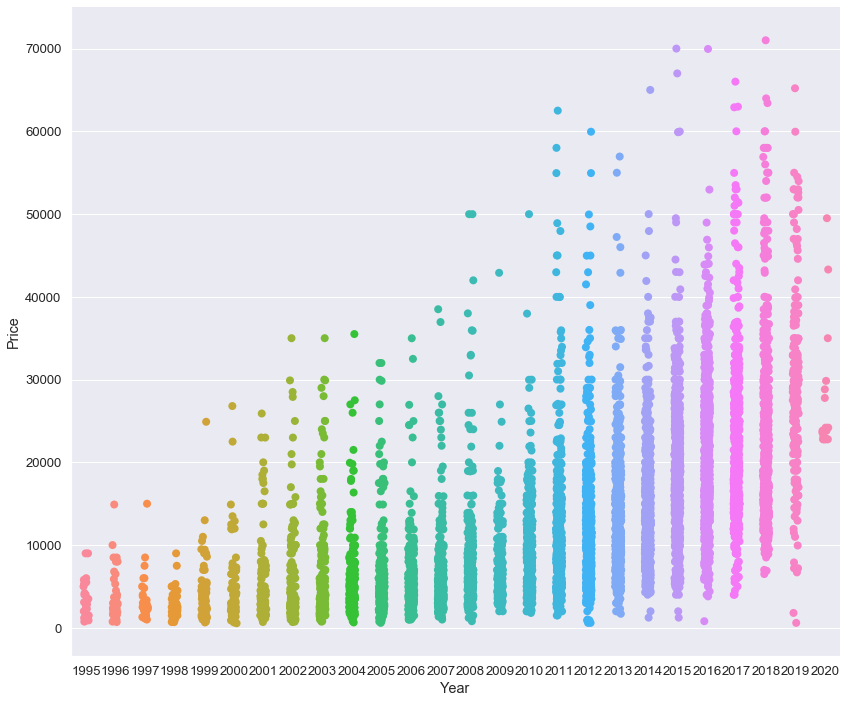

In [28]:
#Catplot by Year and Price.  Looks like Year^2 could be a good feature!
sns.set(font_scale=1.2)
c = sns.catplot(x='Year',y='Price', data=vehicle, height=10, aspect=1.2, s=8)  #s changes marker size
c.set_xticklabels(rotation=0)
plt.show()

In [29]:
#Engineer pair feature.

#Squared feature.    
for elem in ['Year']:
    print(elem + '^2')
    vehicle[elem + '^2'] = vehicle[elem]**2

Year^2


In [30]:
### Build Trim features function

def build_trim_feats(dframe, maxi_trims, min_trim_samp):
    '''
    Return DataFrame with new Trim features.
    
    Arguments
    ---------
    dframe: DataFrame containing model data
    maxi_trims: Max allowed trims -- 1 or 2.
    min_trim_samp: Min count of Model_Trim allowed.  Ex. Min 40 Mustang_GT samples.    
    '''
    
    df1=dframe.copy()
    #Populate max two Trim from RawMake.  Case Insensitive.
    trim_regex=r'\s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD)'
    trim_RawMake = findall_regex_patt(df=df1, target_col='RawMake', regex_patt=trim_regex, max_items=maxi_trims)    
    df1['Trim_RawMake'] = trim_RawMake

    #Populate max two Trim from Title.  Case Insensitive.
    trim_Title = findall_regex_patt(df=df1, target_col='Title', regex_patt=trim_regex, max_items=maxi_trims)
    df1['Trim_Title'] = trim_Title

    #Populate max two Trim from Body.  Model is prefix of search pattern.
    trim_regex_spaces=r'\s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD)\s'
    trim_Body=findall_body_regex_patt(df=df1,target_col='Body',regex_patt=trim_regex_spaces,max_items=maxi_trims)
    df1['Trim_Body'] = trim_Body

    #Scrub Trim in order:  Trim_RawMake, Trim_Title, Trim_Body.
    df1.loc[df1['Trim'].isna(), 'Trim'] = df1.loc[df1['Trim'].isna(), 'Trim_RawMake']
    df1.loc[df1['Trim'] == 'None', 'Trim'] = df1.loc[df1['Trim'] == 'None', 'Trim_Title']
    df1.loc[df1['Trim'] == 'None', 'Trim'] = df1.loc[df1['Trim'] == 'None', 'Trim_Body']

    #Drop redundant Trim columns.
    df1.drop(['Trim_RawMake','Trim_Title','Trim_Body'], axis='columns', inplace=True)

    #Create Model_Trim feature
    df1['Model_Trim'] = df1['Model'] + '_' + df1['Trim']

    #Remove df1 'Model_Trim' counts under threshold.
    thresh=min_trim_samp
    trim_counts=df1['Model_Trim'].value_counts()             
    #print(f'\nDropping Trim with less than {thresh} examples:\n', list(trim_counts[trim_counts < thresh].index))
    trim_over_thresh = trim_counts[trim_counts >= thresh].index  #get thresh+ Model_Trim names
    df1= df1[df1['Model_Trim'].isin(trim_over_thresh)] #boolean filter for the thresh+ Model_Trim names
    print(f'\nOver {thresh} threshold trims:\n', df1['Model_Trim'].value_counts())
    
    #Create Model_Trim_Year feature.  Fixes linear model residuals.
    df1['Year'] = df1['Year'].apply(lambda y: str(y))
    df1['Model_Trim_Year'] = df1['Model'] + '_' + df1['Trim'] + '_' + df1['Year']
    df1['Year'] = df1['Year'].astype('int64')
    return df1

## Parameter Search with Trim and Target Encode Hyperparameters

In [31]:
def hyperparam_search(max_trims, min_trim_samp, min_leaf_samp, smooth):    
    '''Grid search for hyperparameters.'''

    param_grid = {'max_trims': max_trims,'min_trim_samp': min_trim_samp, 'min_leaf_samp': min_leaf_samp, 'smooth': smooth}
    print('grid:', param_grid, '\n')
    pg=ParameterGrid(param_grid)

    #Try each hyperparameter combo.
    results = []
    for gr in pg:  

        #Get Trim for hyperparameter pick: maxi_trims and min_trim_samp.
        tempDF = build_trim_feats(dframe=vehicle, maxi_trims=gr['max_trims'], min_trim_samp=gr['min_trim_samp'])

        #Stratify data - depends on Trim pick.
        from sklearn.model_selection import StratifiedShuffleSplit
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=22)
        for train_index, test_index in sss.split(tempDF, tempDF['Model_Trim']):  #split indices as ilocs
            train = tempDF.iloc[train_index]
            test = tempDF.iloc[test_index]

        #Drop irrelevant columns.
        irrel_cols = ['URL_Vehicle', 'Title', 'Year_in_Title', 'RawMake', 'Make', 'SubLoc', 'Body',\
                      'AttribDictionary', 'ImageDictionary', 'VehicleID', 'VIN', 'TrimAlternate', 'DownFlag']
        train = train.drop(irrel_cols, axis='columns', errors='ignore')
        test = test.drop(irrel_cols, axis='columns', errors='ignore')

        #Target Encode category features with train: Price.
        te_cols = ['Seller', 'Model_Trim_Year']
        train, test=target_encode_categ(encode_cols=te_cols, train=train, test=test, target='Price',\
                   encoder=TargetEncoder(cols=te_cols, min_samples_leaf=gr['min_leaf_samp'],smoothing=gr['smooth']))   


        #*******************************************************************************************
        #Impute missing values - displ, CombMPG, odometer - by regressing on all other features.
        train, test = multivar_impute(train, test,'Price')

        #Drop any understated odometer values.
        filt_used_under_1K = (train['Odometer'] < 1000) & (train['Year^2'] < 2020**2)
        drop_indices = train[filt_used_under_1K].index
        print(f'Drop {len(drop_indices)} incorrect low mileage from train:', drop_indices)
        train = train.drop(index = drop_indices, errors = 'ignore')

        filt_used_under_1K = (test['Odometer'] < 1000) & (test['Year^2'] < 2020**2)
        drop_indices = test[filt_used_under_1K].index
        print(f'# Drop {len(drop_indices)} incorrect low mileage from test:', drop_indices)
        test = test.drop(index = drop_indices, errors = 'ignore')

        #Drop anomaly odometer values.
        filt_over_1M = train['Odometer'] > 400_000
        drop_indices = train[filt_over_1M].index
        print(f'# Drop {len(drop_indices)} incorrect high mileage from train:', drop_indices)
        train = train.drop(index = drop_indices, errors = 'ignore')

        filt_over_1M = test['Odometer'] > 400_000
        drop_indices = test[filt_over_1M].index
        print(f'# Drop {len(drop_indices)} incorrect high mileage from test:', drop_indices)
        test = test.drop(index = drop_indices, errors = 'ignore')
        #*******************************************************************************************

        #User drops certain collinear or noise features.
        user_drops = ['Location', 'Model', 'Trim', 'Year', 'Model_Trim']
        train = train.drop(user_drops, axis='columns', errors='ignore')
        test = test.drop(user_drops, axis='columns', errors='ignore')

        #Run LightGBM fit and predict.
        lgb_model, valid_mae, valid_std, test_mae = run_LGBM(train, test)

        #Save Results
        results.append([gr['max_trims'], gr['min_trim_samp'], gr['min_leaf_samp'], gr['smooth'],\
                        valid_mae, valid_std, test_mae, round(-test_mae/valid_mae*100,1)])
    return results, train, test

#Run hyperparameter grid search.
param_grid = {'max_trims':[2], 'min_trim_samp':[40], 'min_leaf_samp':[1,2], 'smooth':[0.5, 1,2]}
results, _ , _ = hyperparam_search(**param_grid)  #unpack dictionary arguments

grid: {'max_trims': [2], 'min_trim_samp': [40], 'min_leaf_samp': [1, 2], 'smooth': [0.5, 1, 2]} 

## In RawMake, 5131 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2052 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|C

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7815,125769.0,15686.776221,4.35,21.0,4052169.0,9103.878106
9831,51049.0,15686.776221,2.35,22.0,4064256.0,18863.391554


## Grid iters checked: 30 

## mean valid scores: [-2186. -2158. -2094. -2324. -2168. -2325. -2458. -2167. -2175. -3209.
 -2460. -2091. -2220. -3830. -2129. -2234. -2086. -2136. -2115. -2103.
 -2133. -2094. -2602. -2300. -3146. -2064. -2081. -2113. -2096. -2077.]) 

## best valid score: -2064 +- 53 

## Best parameters:
{'bagging_fraction': array([0.08644627]),
 'feature_fraction': 0.6784060708074386,
 'lambda_l1': array([1.34453395e-05]),
 'lambda_l2': array([1.35849293e-07]),
 'learning_rate': array([0.08686539]),
 'max_bin': 35280,
 'max_depth': 5,
 'min_data_in_leaf': 78,
 'n_estimators': 158,
 'num_leaves': 481,
 'subsample_for_bin': 206678}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3155.4
 R^2: 0.8811
 MAE: 2085.6


Weight,Feature
4426.4016 ± 443.9898,Model_Trim_Year
1479.3806 ± 155.6171,Odometer
519.6942 ± 121.5531,Year^2
407.4309 ± 50.9819,CombMPG
300.9797 ± 51.2284,displ
212.9426 ± 51.6071,Seller


## In RawMake, 5131 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2052 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7815,125769.0,15686.776221,4.35,21.0,4052169.0,9107.277559
9831,51049.0,15686.776221,2.35,22.0,4064256.0,18848.531532


## Grid iters checked: 30 

## mean valid scores: [-2204. -2189. -2108. -2333. -2185. -2353. -2467. -2186. -2187. -3215.
 -2488. -2115. -2227. -3839. -2146. -2249. -2115. -2152. -2136. -2114.
 -2147. -2120. -2613. -2305. -3150. -2088. -2112. -2135. -2106. -2099.]) 

## best valid score: -2088 +- 61 

## Best parameters:
{'bagging_fraction': array([0.08644627]),
 'feature_fraction': 0.6784060708074386,
 'lambda_l1': array([1.34453395e-05]),
 'lambda_l2': array([1.35849293e-07]),
 'learning_rate': array([0.08686539]),
 'max_bin': 35280,
 'max_depth': 5,
 'min_data_in_leaf': 78,
 'n_estimators': 158,
 'num_leaves': 481,
 'subsample_for_bin': 206678}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3190.1
 R^2: 0.8785
 MAE: 2119.7


Weight,Feature
4301.5526 ± 378.7963,Model_Trim_Year
1441.3637 ± 177.1204,Odometer
496.9021 ± 117.9979,Year^2
352.3496 ± 50.2524,CombMPG
323.0482 ± 48.1610,displ
196.7206 ± 66.7957,Seller


## In RawMake, 5131 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2052 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7815,125769.0,15686.776221,4.35,21.0,4052169.0,9213.349204
9831,51049.0,15686.776221,2.35,22.0,4064256.0,18577.697568


## Grid iters checked: 30 

## mean valid scores: [-2221. -2172. -2131. -2360. -2191. -2347. -2482. -2195. -2198. -3227.
 -2495. -2140. -2241. -3842. -2137. -2263. -2138. -2162. -2164. -2138.
 -2177. -2136. -2628. -2291. -3159. -2119. -2121. -2142. -2121. -2115.]) 

## best valid score: -2115 +- 63 

## Best parameters:
{'bagging_fraction': array([0.08226274]),
 'feature_fraction': 0.4408086582334479,
 'lambda_l1': array([1.70631968e-07]),
 'lambda_l2': array([0.07053938]),
 'learning_rate': array([0.03622025]),
 'max_bin': 15565,
 'max_depth': 15,
 'min_data_in_leaf': 21,
 'n_estimators': 150,
 'num_leaves': 24,
 'subsample_for_bin': 400007}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3043.6
 R^2: 0.8894
 MAE: 2111.7


Weight,Feature
2662.9423 ± 262.2621,Model_Trim_Year
1601.4668 ± 210.7033,Year^2
1270.0532 ± 135.2394,Odometer
775.2621 ± 118.5502,displ
405.1791 ± 97.8936,CombMPG
218.6298 ± 53.1550,Seller


## In RawMake, 5131 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2052 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7815,125769.0,15686.776221,4.35,21.0,4052169.0,9103.897947
9831,51049.0,15686.776221,2.35,22.0,4064256.0,18863.155059


## Grid iters checked: 30 

## mean valid scores: [-2232. -2198. -2138. -2362. -2200. -2362. -2485. -2217. -2207. -3233.
 -2498. -2146. -2257. -3839. -2168. -2282. -2149. -2175. -2172. -2150.
 -2185. -2140. -2630. -2318. -3155. -2123. -2126. -2148. -2121. -2131.]) 

## best valid score: -2121 +- 54 

## Best parameters:
{'bagging_fraction': array([0.06267572]),
 'feature_fraction': 0.8449265515495977,
 'lambda_l1': array([0.00191179]),
 'lambda_l2': array([0.03977551]),
 'learning_rate': array([0.15483176]),
 'max_bin': 32602,
 'max_depth': 37,
 'min_data_in_leaf': 95,
 'n_estimators': 189,
 'num_leaves': 176,
 'subsample_for_bin': 325177}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3216.0
 R^2: 0.8765
 MAE: 2111.8


Weight,Feature
4676.7901 ± 583.6124,Model_Trim_Year
1520.0230 ± 182.4915,Odometer
556.7793 ± 136.2388,Year^2
369.7314 ± 63.0203,CombMPG
365.2796 ± 59.7941,displ
198.8585 ± 72.8132,Seller


## In RawMake, 5131 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2052 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7815,125769.0,15686.776221,4.35,21.0,4052169.0,9113.109659
9831,51049.0,15686.776221,2.35,22.0,4064256.0,18823.105539


## Grid iters checked: 30 

## mean valid scores: [-2241. -2201. -2133. -2365. -2201. -2377. -2489. -2214. -2192. -3235.
 -2511. -2154. -2269. -3844. -2168. -2284. -2156. -2179. -2183. -2149.
 -2182. -2154. -2638. -2314. -3158. -2130. -2130. -2158. -2138. -2137.]) 

## best valid score: -2130 +- 71 

## Best parameters:
{'bagging_fraction': array([0.07631418]),
 'feature_fraction': 0.7633165167541051,
 'lambda_l1': array([3.3179301e-08]),
 'lambda_l2': array([4.15806678e-05]),
 'learning_rate': array([0.15036415]),
 'max_bin': 27308,
 'max_depth': 13,
 'min_data_in_leaf': 31,
 'n_estimators': 159,
 'num_leaves': 436,
 'subsample_for_bin': 166388}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3129.7
 R^2: 0.883
 MAE: 2128.5


Weight,Feature
4709.1722 ± 281.5409,Model_Trim_Year
1541.6886 ± 206.7789,Odometer
574.8985 ± 136.9817,Year^2
398.4753 ± 67.1477,CombMPG
370.2657 ± 73.0544,displ
193.6369 ± 78.2455,Seller


## In RawMake, 5131 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2052 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESE

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7815,125769.0,15686.776221,4.35,21.0,4052169.0,9280.999347
9831,51049.0,15686.776221,2.35,22.0,4064256.0,18406.398844


## Grid iters checked: 30 

## mean valid scores: [-2257. -2218. -2153. -2391. -2222. -2374. -2509. -2237. -2233. -3240.
 -2514. -2183. -2270. -3852. -2181. -2305. -2181. -2191. -2202. -2161.
 -2214. -2182. -2644. -2322. -3166. -2163. -2164. -2180. -2162. -2156.]) 

## best valid score: -2153 +- 94 

## Best parameters:
{'bagging_fraction': array([0.08770621]),
 'feature_fraction': 0.8154899542050491,
 'lambda_l1': array([6.54278311e-06]),
 'lambda_l2': array([0.0701126]),
 'learning_rate': array([0.14039116]),
 'max_bin': 47414,
 'max_depth': 15,
 'min_data_in_leaf': 40,
 'n_estimators': 160,
 'num_leaves': 302,
 'subsample_for_bin': 496718}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3212.5
 R^2: 0.8768
 MAE: 2183.5


Weight,Feature
4471.1882 ± 280.6839,Model_Trim_Year
1512.1406 ± 221.8086,Odometer
631.5669 ± 118.3805,Year^2
415.3930 ± 87.7867,CombMPG
326.2868 ± 60.3729,displ
205.1150 ± 64.4479,Seller


In [32]:
#Show scores in a table.
scores = pd.DataFrame(results, columns=['max_trims', 'min_trim_samp', 'min_leaf_samp','smooth',\
                                        'valid_MAE','valid_std', 'test_mae','overfit_ratio'])

display(scores)

#Save best hyperparams.
filt_min_idx = [scores.loc[scores['overfit_ratio'] >= 100, 'test_mae'].idxmin()]
best_hyp = scores.loc[filt_min_idx]
max_trims1 = best_hyp['max_trims'].to_numpy()
min_trim_samp1 = best_hyp['min_trim_samp'].to_numpy()
min_leaf_samp1 = best_hyp['min_leaf_samp'].to_numpy()
smooth1 = best_hyp['smooth'].to_numpy()

display(best_hyp)

,max_trims,min_trim_samp,min_leaf_samp,smooth,valid_MAE,valid_std,test_mae,overfit_ratio
0,2,40,1,0.5,-2063.6,53.4,2085.6,101.1
1,2,40,1,1.0,-2088.3,60.9,2119.7,101.5
2,2,40,1,2.0,-2114.5,62.9,2111.7,99.9
3,2,40,2,0.5,-2121.2,53.9,2111.8,99.6
4,2,40,2,1.0,-2130.3,71.1,2128.5,99.9
5,2,40,2,2.0,-2152.7,93.7,2183.5,101.4


,max_trims,min_trim_samp,min_leaf_samp,smooth,valid_MAE,valid_std,test_mae,overfit_ratio
0,2,40,1,0.5,-2063.6,53.4,2085.6,101.1


In [33]:
#Get train and test with the best hyperparam encoding.
param_grid = {'max_trims':max_trims1, 'min_trim_samp':min_trim_samp1, 'min_leaf_samp':min_leaf_samp1, 'smooth':smooth1}
results, train, test = hyperparam_search(**param_grid)  #unpack dictionary to function arguments

grid: {'max_trims': array([2], dtype=int64), 'min_trim_samp': array([40], dtype=int64), 'min_leaf_samp': array([1], dtype=int64), 'smooth': array([0.5])} 

## In RawMake, 5131 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).

## In Title, 2052 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATI

'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7815,125769.0,15686.776221,4.35,21.0,4052169.0,9103.878106
9831,51049.0,15686.776221,2.35,22.0,4064256.0,18863.391554


## Grid iters checked: 30 

## mean valid scores: [-2186. -2158. -2094. -2324. -2168. -2325. -2458. -2167. -2175. -3209.
 -2460. -2091. -2220. -3830. -2129. -2234. -2086. -2136. -2115. -2103.
 -2133. -2094. -2602. -2300. -3146. -2064. -2081. -2113. -2096. -2077.]) 

## best valid score: -2064 +- 53 

## Best parameters:
{'bagging_fraction': array([0.08644627]),
 'feature_fraction': 0.6784060708074386,
 'lambda_l1': array([1.34453395e-05]),
 'lambda_l2': array([1.35849293e-07]),
 'learning_rate': array([0.08686539]),
 'max_bin': 35280,
 'max_depth': 5,
 'min_data_in_leaf': 78,
 'n_estimators': 158,
 'num_leaves': 481,
 'subsample_for_bin': 206678}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3155.4
 R^2: 0.8811
 MAE: 2085.6


Weight,Feature
4383.3749 ± 355.4662,Model_Trim_Year
1477.3848 ± 219.3100,Odometer
520.1575 ± 138.9822,Year^2
411.8410 ± 77.5931,CombMPG
298.6423 ± 53.3151,displ
202.2627 ± 68.5793,Seller


In [34]:
train.head(3)

,Odometer,Seller,Price,displ,CombMPG,Year^2,Model_Trim_Year
7815,125769.0,15686.776221,9995.0,4.350000,21.000000,4052169.0,9103.878106
9831,51049.0,15686.776221,21495.0,2.350000,22.000000,4064256.0,18863.391554
5892,150000.0,7893.248521,19000.0,3.465568,20.804087,4052169.0,12399.288414


### Train Plots - Best Hyperparameters

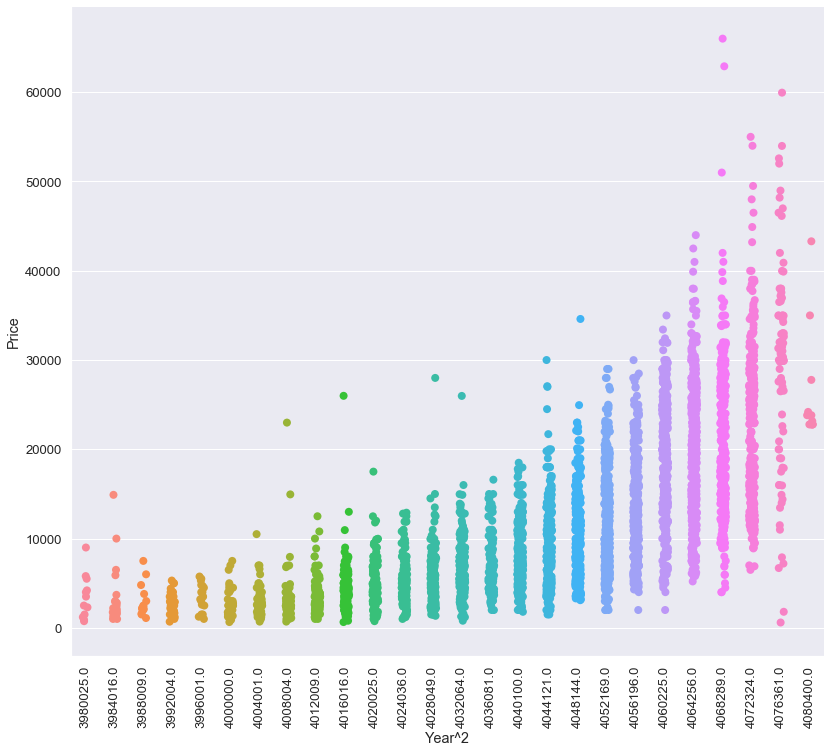

There are 558 unique Model_Trim_Year combos.  High cardinality.


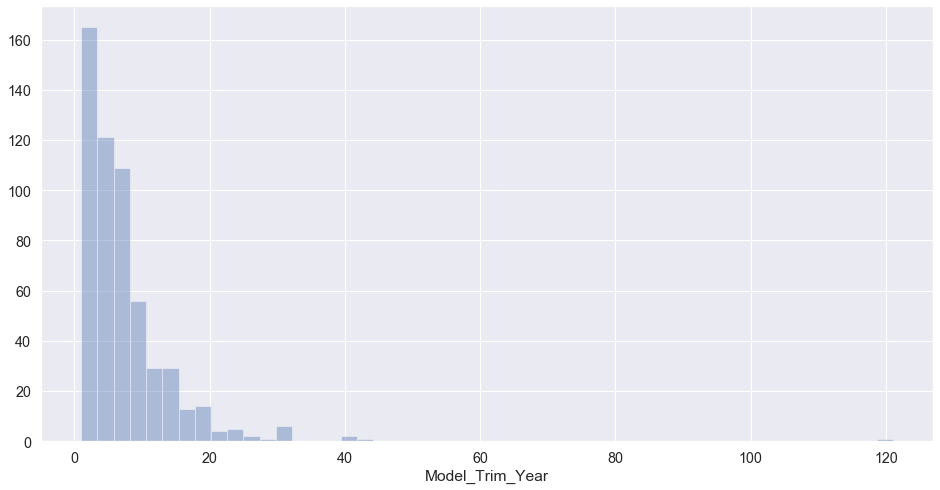

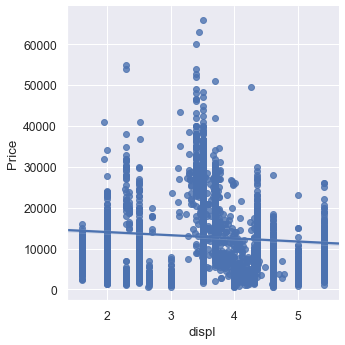

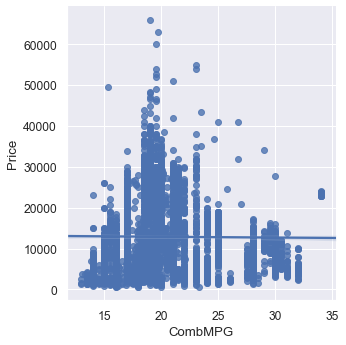

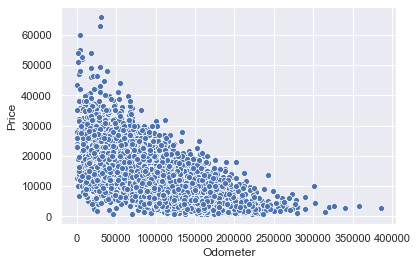

In [35]:
#PLOTS
mydf=train

#Catplot by Year^2 and Price.  Looks like Year^2 could be a good feature!
sns.set(font_scale=1.2)
c2 = sns.catplot(x='Year^2',y='Price', data=mydf, height=10, aspect=1.2, s=8)  #s changes marker size
c2.set_xticklabels(rotation=90)
plt.show()

#Model_Trim_Year has rare categories, so target encoding will need regularization.
print(f"There are {len(mydf['Model_Trim_Year'].value_counts())} unique Model_Trim_Year combos.  High cardinality.")
plt.figure(figsize=(16,8))
sns.set(font_scale=1.3)
sns.distplot(mydf['Model_Trim_Year'].value_counts(), kde=False)
plt.show()
    
#Scatter by Displacement vs Price, and Model.
sns.set(font_scale=1.1)
sns.lmplot(x='displ',y='Price',data=mydf)  #s changes marker size
plt.show()

#Scatter by MPG vs Price.
sns.set(font_scale=1.1)
sns.lmplot(x='CombMPG',y='Price',data=mydf)  #s changes marker size
plt.show()

#Scatter by Odometer vs Price.  Will drop mileages over 400K.
sns.set(font_scale=1.0)
sns.scatterplot(x='Odometer',y='Price',data=mydf)  #s changes marker size
plt.show() 

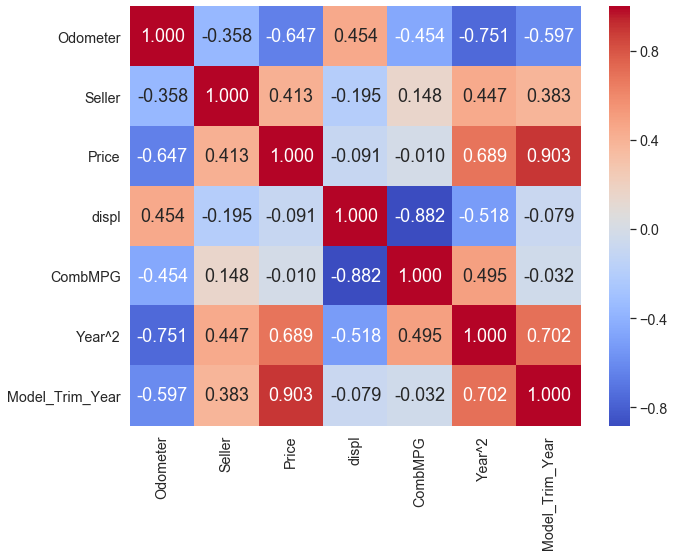

In [46]:
#Show correlation heatmap.  Keeping the collinear features may help prediction, while making the 
#linear regression coefficients less interpretable.
plt.figure(figsize=(10,8))
sns.set(font_scale=1.3)
sns.heatmap(train.corr(), cmap='coolwarm', annot=True, annot_kws={"size": 18}, fmt=".3f")
plt.tight_layout()

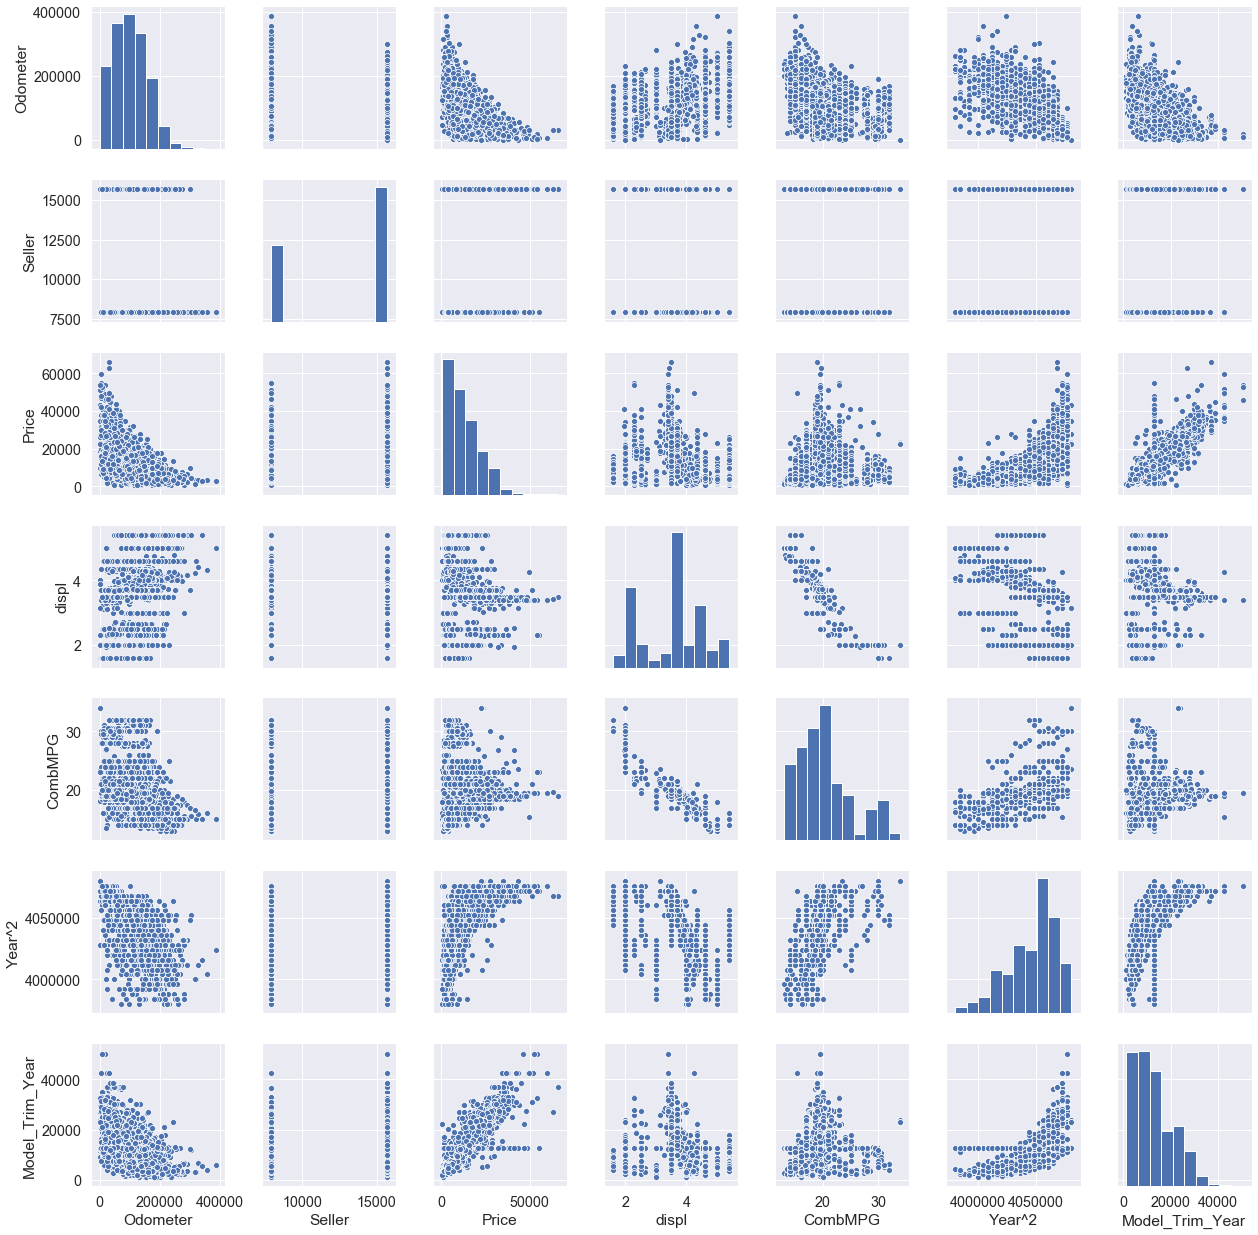

In [37]:
#Investigate outliers revealed in pairplot.
sns.set(font_scale=1.3)
sns.pairplot(train)
plt.show()

### Save Preprocessed data - train and test

In [38]:
#Save tables to PostgreSQL database.
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import JSON, JSONB
engine=create_engine("postgresql://postgres@localhost:5432/postgres")

#Write vehicle table with json
vehicle.to_sql(name='vehicle', con=engine, if_exists='replace', index=True,\
               dtype={'AttribDictionary': JSONB, 'ImageDictionary': JSONB})

#Write train and test
train.to_sql(name='trainClean', con=engine, if_exists='replace', index=True)
test.to_sql(name='testClean', con=engine, if_exists='replace', index=True)

In [39]:
print('train shape:', train.shape, '| test shape:', test.shape)

train shape: (4109, 7) | test shape: (455, 7)
